In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler

import nltk
# from nltk import word_tokenize - нужно nltk.download('punkt')

from nltk import wordpunct_tokenize, wordnet
from nltk.stem import wordnet as WordNetLem
from nltk.stem import SnowballStemmer, StemmerI

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import doc2vec
from gensim.models import LdaModel, LdaMulticore
from gensim.models import LsiModel
from gensim import models

from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
stop_words = \
    ['и', 'в', 'во',  'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
     'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от',
     'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже',
     'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там',
     'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы',
     'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под',
     'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь',
     'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех',
     'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот',
     'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя',
     'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть', 'том', 'нельзя', 'такой',
     'им', 'более', 'всегда', 'конечно', 'всю', 'между','не', ]
stop_words.extend(['очень', 'ооочень', 'это', 'данное'])

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Авалон/Диплом/data')

#  Функции

In [ ]:
# токенизация по словам (с удалением пунктуации)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#  Загрузка данных

In [ ]:
df = pd.read_csv('coffee.csv')
df['rating'] = df['rating'].astype('float16')

df_tmp = df.iloc[:500]['text']
df_tmp[3]

FileNotFoundError: ignored

# Предобработка

In [ ]:
# объединение НЕ с ближайшим словом
start_text = [text_x.replace("не ", 'не') for text_x in df_tmp]

In [2]:
# есть проблема - nчто можно улучшить - маловато места посадки. n английская остается.
tokenized = list(sent_to_words(start_text))
tokenized[5][:10]

NameError: ignored

In [3]:
# стемминг и удаление стоп слов
stemmer = SnowballStemmer('russian')

stemming = []
for sentence in tokenized:
    stemming.append(list(stemmer.stem(word_x) for word_x in sentence if word_x not in stop_words))
stemming[5][:10], len(stemming[0])

NameError: ignored

In [ ]:
# сборка
tok_stem_text = []
for word_x in stemming:
    tok_stem_text.append(" ".join(word_x))
tok_stem_text[0]

'самы большо плюс набережн шикарны вид мор красив уютн собствен плюс законч огорча отношен посетител официант неприветлив не здравству не свидан лиц недовольн неприятн не хочет смотрет так кухн оставля жела лучш люл кебаб кост попада шашлык говядин сухо невкусны отдых позитив денег не жале хочет приход туд нам рад'

In [ ]:
# сборка с учетом не
tok_stem_text = []
for sentence_x in stemming:
    string_tmp = " ".join(sentence_x).replace("не ", 'не')
    tok_stem_text.append(string_tmp)

# заново разбиваем на токены
tokenized = list(sent_to_words(tok_stem_text))

# вывод результата
tok_stem_text[0], tokenized[0][:10]

# Кодирование - gensim doc2bow

In [ ]:
dictionary = corpora.Dictionary(stemming)
corpus = [dictionary.doc2bow(l) for l in stemming]

# би/три граммы

In [ ]:
# Build the bigram models
bigram = gensim.models.phrases.Phrases(stemming, min_count=3, threshold=10)

# Construct bigram
print(bigram[stemming[0]])

['самы', 'большо', 'плюс', 'набережн', 'шикарны', 'вид', 'мор', 'красив', 'уютн', 'собствен', 'плюс', 'законч', 'огорча', 'отношен', 'посетител', 'официант', 'неприветлив', 'не', 'здравству', 'не', 'свидан', 'лиц', 'недовольн', 'неприятн', 'не', 'хочет', 'смотрет', 'так', 'кухн', 'оставля_жела', 'лучш', 'люл', 'кебаб', 'кост', 'попада', 'шашлык', 'говядин', 'сухо', 'невкусны', 'отдых', 'позитив', 'денег', 'не', 'жале', 'хочет_приход', 'туд', 'нам', 'рад']


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(stemming, min_count=2, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[stemming], threshold=1)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[stemming[0]]])

['самы', 'большо', 'плюс', 'набережн', 'шикарны', 'вид_мор', 'красив', 'уютн', 'собствен', 'плюс', 'законч', 'огорча', 'отношен_посетител', 'официант', 'неприветлив', 'не', 'здравству', 'не', 'свидан', 'лиц', 'недовольн', 'неприятн', 'не_хочет', 'смотрет', 'так', 'кухн', 'оставля_жела_лучш', 'люл', 'кебаб', 'кост', 'попада', 'шашлык', 'говядин', 'сухо', 'невкусны', 'отдых', 'позитив', 'денег', 'не', 'жале', 'хочет_приход', 'туд', 'нам', 'рад']


In [ ]:
result_coding = []
for text_x in stemming:
    # result_coding.append(trigram_mod[bigram_mod[text_x]])
    result_coding.append(bigram_mod[text_x])
result_coding[0][:10]

['глубинк',
 'стран',
 'сво',
 'проявлен',
 'ассортимент',
 'столовск',
 'интерьер',
 'качеств',
 'цен',
 'приемлем']

In [ ]:
dictionary = corpora.Dictionary(result_coding)
corpus = [dictionary.doc2bow(l) for l in result_coding]

In [ ]:
df_tmp[6]

'1. Доставка очень долгая, на рекламной брошюре написано от  500 р доставка бесплатно, а по факту заплатили 100 р за доставку. Чек был на 577р\\n2. Долго плевались от нагара который был на сковородке (подноса) с мясом, хруст на зубах не приятен. \\nИспорченное мнение от вашего заведения. \n'

# Моделирование

In [ ]:
# Обучение
LDA_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5)

In [ ]:
# интерпретация данных
doc_topics, word_topics, phi_values = LDA_model.get_document_topics(bow, per_word_topics=True)

In [ ]:
# See the topics
LDA_model.print_topics(-1)

[(0,
  '0.006*"заведен" + 0.006*"мест" + 0.006*"минут" + 0.006*"официант" + 0.005*"стол" + 0.005*"заказ" + 0.005*"так" + 0.005*"нам" + 0.004*"сказа" + 0.004*"ед"'),
 (1,
  '0.006*"заведен" + 0.006*"прост" + 0.005*"ед" + 0.005*"вкусн" + 0.004*"так" + 0.004*"мест" + 0.004*"нам" + 0.004*"сказа" + 0.003*"одн" + 0.003*"каф"'),
 (2,
  '0.009*"заведен" + 0.007*"заказ" + 0.006*"прост" + 0.006*"блюд" + 0.005*"ед" + 0.005*"вкусн" + 0.005*"итог" + 0.004*"кухн" + 0.004*"так" + 0.004*"заказа"'),
 (3,
  '0.008*"официант" + 0.007*"ед" + 0.006*"заведен" + 0.005*"так" + 0.005*"вкусн" + 0.005*"прост" + 0.005*"блюд" + 0.005*"мен" + 0.004*"принесл" + 0.004*"цен"'),
 (4,
  '0.007*"блюд" + 0.007*"мест" + 0.007*"заведен" + 0.006*"цен" + 0.005*"вкусн" + 0.005*"хорош" + 0.004*"одн" + 0.004*"ед" + 0.004*"так" + 0.004*"заказ"')]

In [ ]:
# нужна модель, токенизированные по предложениям токены, словарь gensim
CoherenceModel(model=LDA_model, texts=stemming, dictionary=dictionary, coherence='c_v').get_coherence()

0.46030285453774705

# Результаты отзывов всех

In [ ]:
def compute_coherence_values(text_tokens, stop, start=2, step=1):

    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    text_tokens : List of input texts
    stop : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    dictionary = corpora.Dictionary(text_tokens)
    corpus = [dictionary.doc2bow(l) for l in text_tokens]

    coherence_values = {}
    model_list = []
    for num_topics in tqdm(range(start, stop, step)):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_tokens, dictionary=dictionary, coherence='c_v')
        coherence_values[num_topics] = coherencemodel.get_coherence()

    return model_list, coherence_values

# Учет Не + униграммы

In [ ]:
# сочетания с НЕ, униграммы, doc2bow,
models_1, num_topics__values_1 = compute_coherence_values(stemming, 300, step=3)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [04:13<00:00,  7.69s/it]


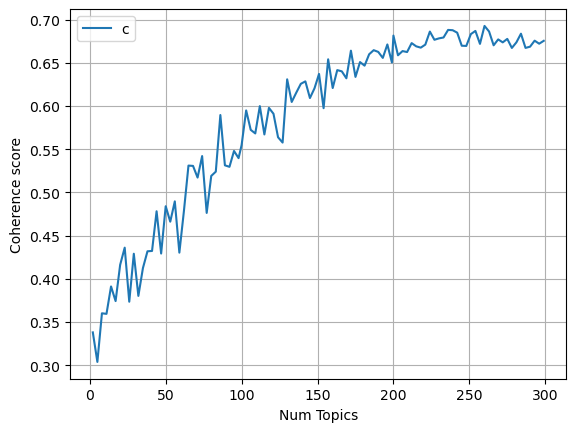

In [ ]:
# Show graph
plt.plot(num_topics__values_1.keys(), num_topics__values_1.values())
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

# Учет НЕ + биграммы

In [ ]:
# сочетания с НЕ, униграммы, doc2bow,
models_2, num_topics__values_2 = compute_coherence_values(stemming, 200, step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [06:52<00:00, 10.31s/it]


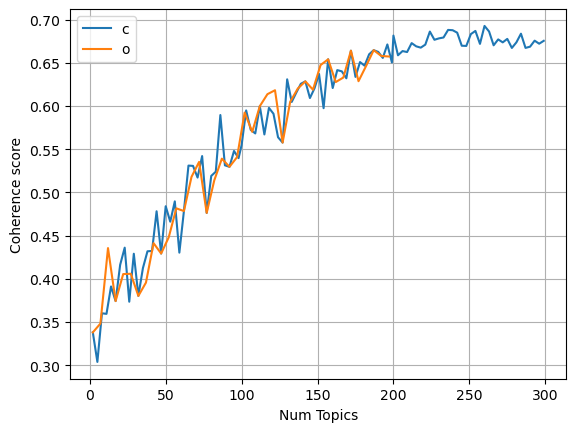

In [ ]:
# Show graph
plt.plot(num_topics__values_1.keys(), num_topics__values_1.values())
plt.plot(num_topics__values_2.keys(), num_topics__values_2.values())   # желтая линия
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

# Учет Не + униграммы + только положительные

In [ ]:
df_tmp = df[df['rating'] == 5].iloc[:500]['text']
df_tmp[1]

'5 из 5🖤 Пил кофе и в Риме, и в  Париже, но вкуснее, чем капуч на фундучном молоке с фирменными сливками Джинжу, не пробовал ничего! Десерты тоже очень необычные. Ребята - бариста большие молодцы! \\n\\nЧто можно улучшить? Маловато места, с посадкой можно что-то придумать?\n'

In [ ]:
# сочетания с НЕ, униграммы, doc2bow,
models_3, num_topics__values_3 = compute_coherence_values(stemming, 200, step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [06:19<00:00,  9.48s/it]


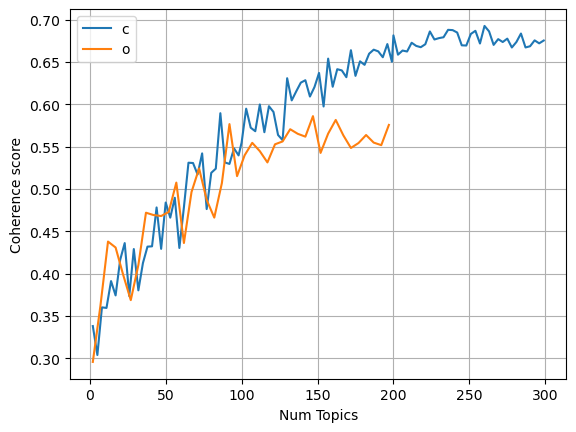

In [ ]:
plt.plot(num_topics__values_1.keys(), num_topics__values_1.values())   # желтая линия
plt.plot(num_topics__values_3.keys(), num_topics__values_3.values())   # желтая линия
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()